# Plotting Pandapower Networks

This tutorial shows you how to plot pandapower networks. 

We use matplotlib collections to plot the stations or lines in the network. There are different types of elements in matplotlib, like lines, circles, rectangles etc. These elements are bundled into collections, where one objects holds many elements of the same type (see matplotlib documentation: http://matplotlib.org/api/collections_api.html).

The plotting module provides several functions that create collections from pandapower networks. In this interactive tutorial, we show you how to use these functions to plot networks.

## Simple Plotting

There is a convenience function that allows you to plot networks fast without having to gain an in depths understanding of the pandapower plotting module. The simple_plot function can be called as follows:

In [1]:
import numpy as np
import geojson
from pandapower.networks import mv_oberrhein
from pandapower.topology.create_graph import create_nxgraph
from pandapower.topology.graph_searches import calc_distance_to_bus, connected_components
from pandapower.plotting.simple_plot import simple_plot
from pandapower.run import runpp
from pandapower.plotting.plotting_toolbox import get_collection_sizes
from pandapower.plotting import create_line_collection, create_bus_collection, draw_collections, create_annotation_collection

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)


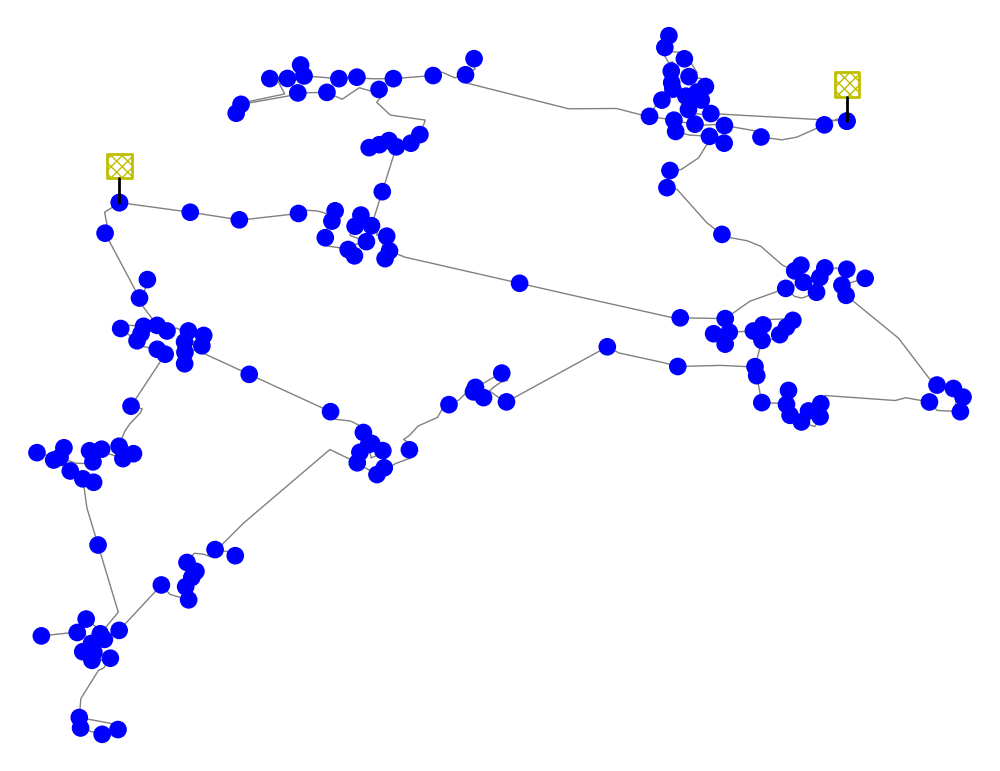

<Axes: >

In [2]:
# load example net (MV Oberrhein)
net = mv_oberrhein()
# simple plot of net with existing geocoordinates or generated artificial geocoordinates
simple_plot(net, show_plot=True)

This function plots geodata if it is available and generates generic geodata if none is available. Note that you need the igraph package to generate geocoordinates (see last chapter of this tutorial).



## Simple Highlighting Plot

The function ``simple_hl_plot()`` highlights lines or buses in a simple network plot. The highlighted elements are displayed in red and enlarged. 
Additionally, buses and lines can be located directly in the plot by hovering the mouse over a specific line or bus. 
The name and index will be shown in a small box. The simple_hl_plot function can be called as follows:

In [3]:
from pandapower.plotting.simple_plot import simple_hl_plot

# load example net (MV Oberrhein)
net = mv_oberrhein()
# we want to highlight overhead power liens and connected buses
ol_lines = net.line.loc[net.line.type=="ol"].index
ol_buses = net.bus.index[net.bus.index.isin(net.line.from_bus.loc[ol_lines]) |
                         net.bus.index.isin(net.line.to_bus.loc[ol_lines])]

simple_hl_plot(net, hl_lines=ol_lines, hl_buses=ol_buses)

ImportError: cannot import name 'simple_hl_plot' from 'pandapower.plotting.simple_plot' (C:\Users\jwiemer\miniconda3\envs\py311\Lib\site-packages\pandapower\plotting\simple_plot.py)

We get an interactive plot with hover functionality that display overhead power lines and connected buses enlarged in red.

## Plotting Collections

If you want to have full control over the layout of your plot, you can individually create and plot collections with the pandapower plotting module.

In [ ]:
try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]
%matplotlib inline

First, we plot only the lines and buses of an example network. This is done by creating a line collection for all lines and a bus collection for all buses. We then plot both collections with the draw_collections function:

In [ ]:
net = mv_oberrhein()
sizes = get_collection_sizes(net)

lc = create_line_collection(net, net.line.index, color="grey", zorder=1) #create lines
bc = create_bus_collection(net, net.bus.index, size=sizes['bus'], color=colors[0], zorder=2) #create buses
draw_collections([lc, bc], figsize=(8,6)) # plot lines and buses

## Plot Bus IDs

Bus indices (names, or other annotations) can be plotted by creating an additional collection.

In this example, we plot all bus indices. Therefore we create a new collection (bic) with create_annotation_collection.
For this we need a list of strings (Texts) which contain the texts to plot and their coordinates (coords, tuples of coordinates).

In [ ]:
buses = net.bus.index.tolist() # list of all bus indices
coords = net.bus.geo.apply(geojson.loads).apply(geojson.utils.coords).apply(next).values

bic = create_annotation_collection(size=sizes['bus'] * 1.5, texts=np.char.mod('%d', buses), coords=coords, zorder=10, color=colors[1])
draw_collections([lc, bc, bic], figsize=(80,60)) # plot lines, buses and bus indices

## Highlighting

Specific lines or buses can be highlighted by creating extra line collections in different colors.

In this example, we plot lines that are longer than 2 km green and buses with a voltage below 0.98 pu red.

First, we create a line collection for all lines in grey and a line collection for only the long lines in green:

In [ ]:
net = mv_oberrhein()
long_lines = net.line[net.line.length_km > 2.].index
lc = create_line_collection(net, net.line.index, color="grey", zorder=1)
lcl = create_line_collection(net, long_lines, color="g", zorder=2)

Notice that the zorder is higher for the long line collection. This ensures that the green line collection is plotted over the grey line collection.

We then conduct a loadflow and create bus collections in the same way:

In [ ]:
runpp(net)
low_voltage_buses = net.res_bus[net.res_bus.vm_pu < 0.98].index
bc = create_bus_collection(net, net.bus.index, size=sizes['bus'], color=colors[0], zorder=10)
bch = create_bus_collection(net, low_voltage_buses, size=sizes['bus'], color=colors[2], zorder=11)
draw_collections([lc, lcl, bc, bch], figsize=(8,6))

Another way to highlight something is to use a different shape using the patch_type argument of the create_bus collection. You can for example mark the slack bus with a rectangle shape like this:

In [ ]:
net = mv_oberrhein()
lc = create_line_collection(net, net.line.index, color="grey", zorder=1) #create lines
bc = create_bus_collection(net, net.bus.index, size=sizes['bus'], color=colors[0], zorder=2) #create buses
sc = create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=sizes['bus'], color=colors[4], zorder=11)
draw_collections([lc, bc, sc], figsize=(8,6)) # plot lines and buses

## Highlighting with the Topology Package

Combining the [topology package](topology.ipynb) with the plotting package allows highlighting of structural features of the network. For example, we can highlight all buses closer than 5 km to a transformer station:

In [ ]:
net = mv_oberrhein()
close_buses = set()
for slack in net.ext_grid.bus:
    d = calc_distance_to_bus(net, slack)
    close_buses |= set(d[d < 5].index)

bc = create_bus_collection(net, net.bus.index, size=sizes['bus'], color=colors[0], zorder=1)
bch = create_bus_collection(net, close_buses, size=sizes['bus'], color=colors[2], zorder=2)
lc = create_line_collection(net, net.line.index, zorder=1, color="grey")
sc = create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=sizes['bus'], color=colors[4], zorder=11)
draw_collections([lc, bc, bch, sc], figsize=(8,6))

Or to highlight the radiality of the network, plot the seperate feeders in different colors:

In [ ]:
net = mv_oberrhein()
mg = create_nxgraph(net, nogobuses=set(net.trafo.lv_bus.values) | set(net.trafo.hv_bus.values))
collections = []
for color, area in zip(colors, connected_components(mg)):
    collections.append(create_bus_collection(net, area, size=sizes['bus'], color=color, zorder=2))
collections.append(create_line_collection(net, net.line.index, zorder=1, color="grey"))
collections.append(create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=sizes['bus'],
                                              color=colors[4], zorder=11))
draw_collections(collections, figsize=(8,6))

## Direct Line Connections

Line collections are plotted with the geographical coordinates of the lines that are stored in net.line_geodata by default. You can also plot lines as direct connections between the buses, by calling the create_line_collection function with use_bus_geodata=True:

In [ ]:
net = mv_oberrhein()
bc = create_bus_collection(net, net.bus.index, size=sizes['bus'], color=colors[0], zorder=10)
lcd = create_line_collection(net, net.line.index, use_bus_geodata=True, color="grey", linewidths=2.)
sc = create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=sizes['bus'],
                                              color=colors[4], zorder=11)
draw_collections([lcd, bc, sc])

As a comparison, here are the lines with direct connections (solid) and the line trails from line_geodata (dashed):

In [ ]:
net = mv_oberrhein()
bc = create_bus_collection(net, net.bus.index, size=sizes['bus'], color=colors[0], zorder=10)
lcd = create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linewidths=2., use_bus_geodata=True)
lc = create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linestyles="dashed", linewidths=2.)
sc = create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=sizes['bus'],
                                              color=colors[4], zorder=11)
draw_collections([lc, lcd, bc, sc])